## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2015-02-26 21:42:53,11
2015-02-26 21:47:53,10
2015-02-26 21:52:53,3
2015-02-26 21:57:53,4
2015-02-26 22:02:53,9
...,...
2015-04-23 02:27:53,1
2015-04-23 02:32:53,4
2015-04-23 02:37:53,3


In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[1]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

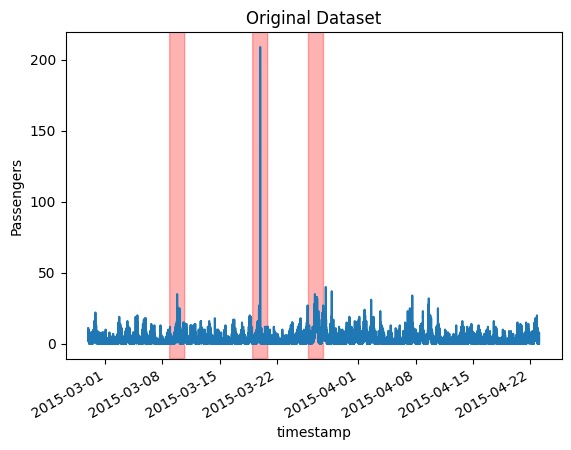

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing: First 60% for test, last 40% for train

In [6]:
# Splitting to train and test
test_ratio =0.6
tr_data = data.iloc[int(len(data) * test_ratio) :]
tst_data = data.iloc[: int(len(data) * test_ratio)]
data_with_anomaly= data_with_anomaly.iloc[: int(len(data) * test_ratio)]

In [7]:
tr_data

,value
timestamp,
2015-04-01 00:47:53,3
2015-04-01 00:52:53,4
2015-04-01 00:57:53,1
2015-04-01 01:02:53,4
2015-04-01 01:07:53,6
...,...
2015-04-23 02:27:53,1
2015-04-23 02:32:53,4
2015-04-23 02:37:53,3


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 6361


Each sample is five minutes apart, so 288 samples accounts for a day

In [9]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (6074, 288, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = vae.fit(
    train,
    train,
    epochs= 1000,
    batch_size= 256,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/1000


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 78073.7344 - val_loss: 44870.8789
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 61971.0312 - val_loss: 32525.6719
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 47803.6250 - val_loss: 27524.2539
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 44290.0938 - val_loss: 27207.3750
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 42474.1523 - val_loss: 26880.0684
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 41239.3555 - val_loss: 26652.5410
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 40479.1680 - val_loss: 26531.6250
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 39857.8320 - val_loss: 26375.7402
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 38939.0352 - val_loss: 26227.4121
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 38878.7500 - val_loss: 26244.9961
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 

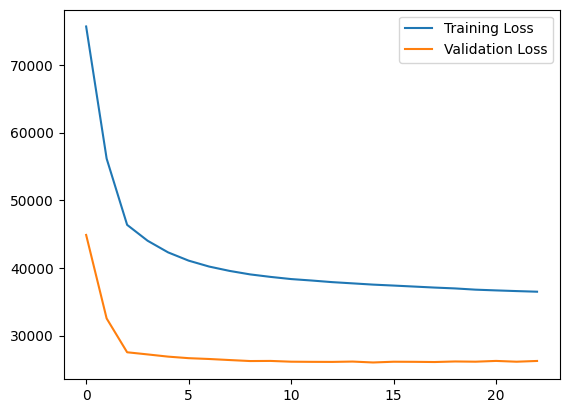

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(6074, 1)


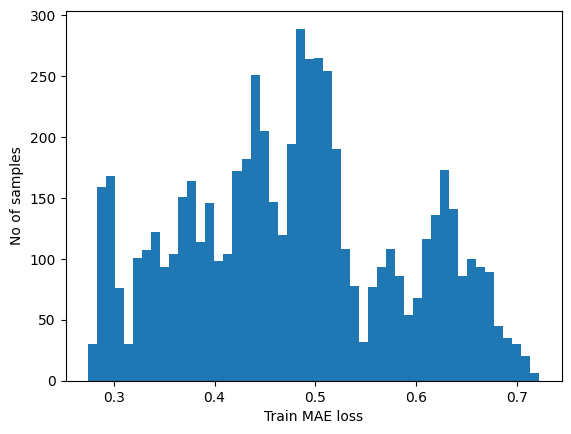

Reconstruction error threshold:  0.7216409086780852


In [13]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [14]:
print(train_pred.shape)

(6074, 288, 1)


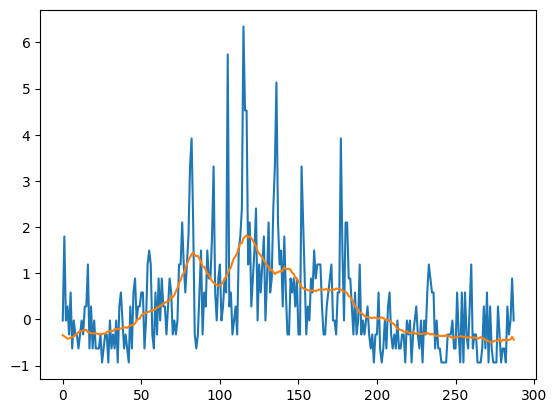

In [15]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

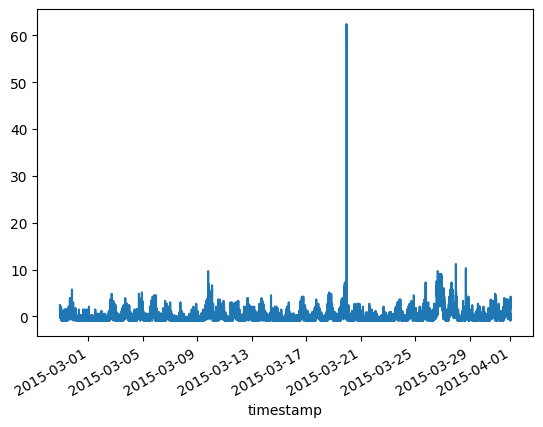

Test input shape:  (9254, 288, 1)
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(9254, 1)


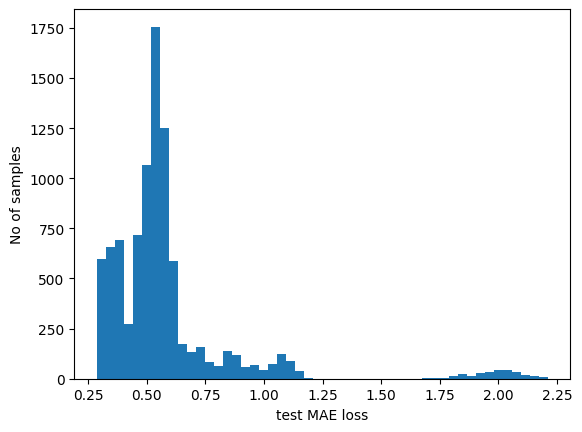

Number of anomaly samples:  1315
Indices of anomaly samples:  (array([2874, 2875, 2876, ..., 9223, 9224, 9253], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [16]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [17]:
anomalous_data_indices = []
for ind in range(len(anomalies)):
    if anomalies[ind]:
        anomalous_data_indices.append(ind)

In [18]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [19]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 6064, 6065, 6066, 6067, 6068, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103

In [20]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2015-03-09 21:07:53,22
2015-03-09 21:12:53,17
2015-03-09 21:17:53,12
2015-03-09 21:22:53,13
2015-03-09 21:27:53,9
...,...
2015-03-27 16:42:53,5
2015-03-27 16:47:53,6
2015-03-27 16:52:53,6


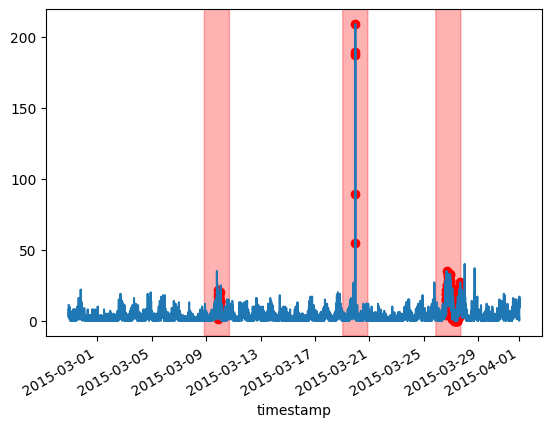

In [21]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()

In [22]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")) for start, end in instances_of_anomaly]
res= score_fn(list(df_subset.index), anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 